In [56]:
import tensorflow as tf
import scipy as sp
import numpy as np
import pandas as pd
import re
import hashlib
from sklearn.preprocessing import StandardScaler

import os
from pathlib import Path
import IPython.display as ipd
import cProfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
%matplotlib inline


In [96]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1 # ~134M
"""Determines which data partition the file should belong to.

We want to keep files in the same training, validation, or testing sets even if new ones are added over time. This makes it less likely that testing samples will accidentally be reused in training when long runs are restarted for example. To keep this stability, a hash of the filename is taken and used to determine which set it should belong to. This determination only depends on the name and the set proportions, so it won't change as other files are added.

It's also useful to associate particular files as related (for example words spoken by the same person), so anything after 'nohash' in a filename is ignored for set determination. This ensures that 'bobby_nohash_0.wav' and 'bobby_nohash_1.wav' are always in the same set, for example.

Args: filename: File path of the data sample. validation_percentage: How much of the data set to use for validation. testing_percentage: How much of the data set to use for testing.

Returns: String, one of 'training', 'validation', or 'testing'. """ 

def which_set(filename, validation_percentage, testing_percentage): 
    base_name = os.path.basename(filename) 
    # We want to ignore anything after 'nohash' in the file name when 
    # deciding which set to put a wav in, so the data set creator has a way of # grouping wavs that are close variations of each other. 
    hash_name = re.sub(r'nohash.*$', '', base_name) 
    # This looks a bit magical, but we need to decide whether this file should # go into the training, testing, or validation sets, and we want to keep 
    # existing files in the same set even if more files are subsequently 
    # added.   
    # To do that, we need a stable way of deciding based on just the file name 
    # itself, so we do a hash of that and then use that to generate a 
    # probability value that we use to assign it. 
    hash_name_hashed = hashlib.sha1(hash_name.encode("utf8")).hexdigest() 
    percentage_hash = ((int(hash_name_hashed, 16) % (MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))
    #print(percentage_hash)
    if percentage_hash < validation_percentage: 
        result = 'validation' 
    elif percentage_hash < (testing_percentage + validation_percentage): 
        result = 'testing' 
    else: 
        result = 'training' 
    return result

In [35]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [81]:
folders = os.listdir("../data/raw/train/audio")
print(folders)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


In [84]:
train_labels = os.listdir(train_audio_path)
train_labels.remove('_background_noise_')
print(f'Number of labels: {len(train_labels)}')

labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence']

train_file_labels = dict()
for label in train_labels:
    files = os.listdir(train_audio_path + '/' + label)
    for f in files:
        train_file_labels[label + '/' + f] = label

train = pd.DataFrame.from_dict(train_file_labels, orient='index')
train = train.reset_index(drop=False)
train = train.rename(columns={'index': 'file', 0: 'folder'})
train = train[['folder', 'file']]
train = train.sort_values('file')
train = train.reset_index(drop=True)
print(train.shape)
def remove_label_from_file(label, fname):
    return fname[len(label)+1:]

train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

Number of labels: 30
(64721, 2)


In [88]:
labels_to_keep

['yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go',
 'silence']

In [87]:
train

,folder,file,label
0,bed,00176480_nohash_0.wav,unknown
1,bed,004ae714_nohash_0.wav,unknown
2,bed,004ae714_nohash_1.wav,unknown
3,bed,00f0204f_nohash_0.wav,unknown
4,bed,00f0204f_nohash_1.wav,unknown
5,bed,012c8314_nohash_0.wav,unknown
6,bed,012c8314_nohash_1.wav,unknown
7,bed,0132a06d_nohash_0.wav,unknown
8,bed,0135f3f2_nohash_0.wav,unknown
9,bed,0137b3f4_nohash_0.wav,unknown


In [118]:
train_audio_path = '../data/raw/train/audio/'
test_perc = 0
val_perc = 10
raw_train = []
raw_dev = []
for row in train.itertuples():
    folder = row[1]
    file = row[2]
    label = row[3]
    filename = folder + "/" + file
    which = which_set(f"{train_audio_path}/{filename}",val_perc,test_perc)
    sample_rate, samples = wavfile.read(train_audio_path + filename)
    std_samples = StandardScaler().fit_transform(samples.astype('float64').reshape(-1, 1)).reshape(-1,)
    freqs, times, spectrogram = log_specgram(std_samples, sample_rate)
    if which == 'training':
        raw_train.append((spectrogram, label))
    else:
        raw_dev.append((spectrogram,label))

In [127]:
len(raw_train)

58436

In [130]:
[x[1] for x in raw_dev]

['unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'un

In [128]:
len(raw_dev)

6285

In [133]:
for label in labels_to_keep + ['unknown']:
    print (f"{label} dev count: {len([x for x in raw_train if x[1] == label])}")

yes dev count: 2143
no dev count: 2149
up dev count: 2136
down dev count: 2118
left dev count: 2128
right dev count: 2160
on dev count: 2140
off dev count: 2130
stop dev count: 2140
go dev count: 2162
silence dev count: 0
unknown dev count: 37030


In [31]:
def testit():
    for i in range (1, 1000):
        which_set("../data/raw/train/audio/bed/0a7c2a8d_nohash_0.wav",5,5)

In [32]:
cProfile.run('testit()')

32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.39429319198648
32.3942931

In [51]:
sample_rate

16000

In [59]:
samples.mean()

2.88225

In [111]:
train_audio_path = '../data/raw/train/audio/'
filename = '/yes/0ff728b5_nohash_2.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [112]:
std_samples = StandardScaler().fit_transform(samples.reshape(-1, 1)).reshape(-1,)

C:\Users\kosma\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\kosma\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [107]:
std_samples = samples

Text(0.5, 0, 'Seconds')

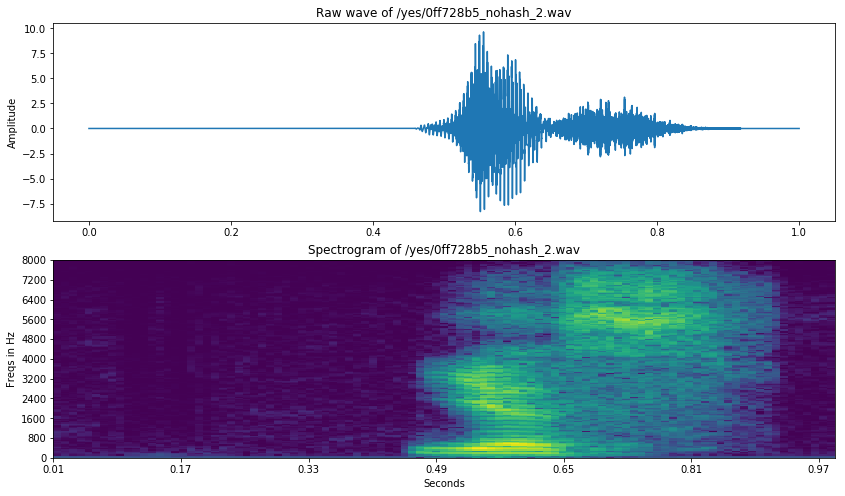

In [113]:
freqs, times, spectrogram = log_specgram(std_samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(std_samples), sample_rate), std_samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

Text(0.5, 0, 'Seconds')

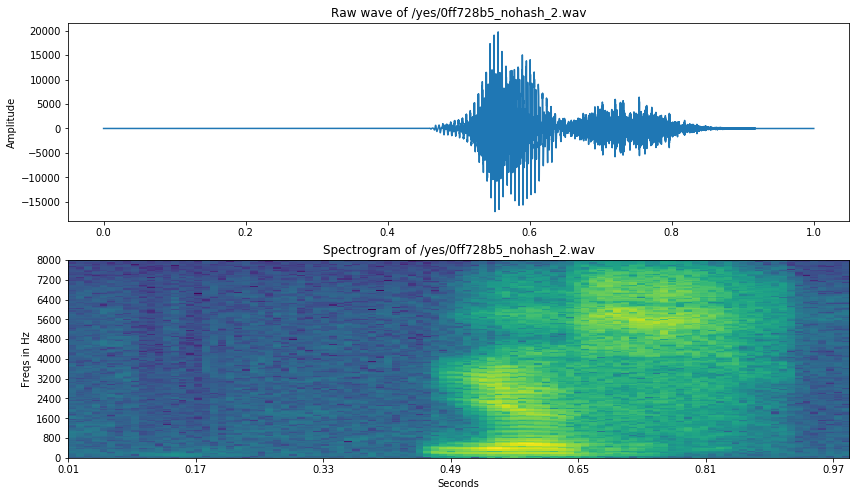

In [77]:
freqs, times, spectrogram = log_specgram(std_samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(std_samples), sample_rate), std_samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [119]:
train_audio_path = '../data/raw/train/audio/'
filename = '/yes/0ff728b5_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [123]:
std_samples = StandardScaler().fit_transform(samples.reshape(-1, 1)).reshape(-1,)

C:\Users\kosma\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\kosma\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [121]:
std_samples = samples

Text(0.5, 0, 'Seconds')

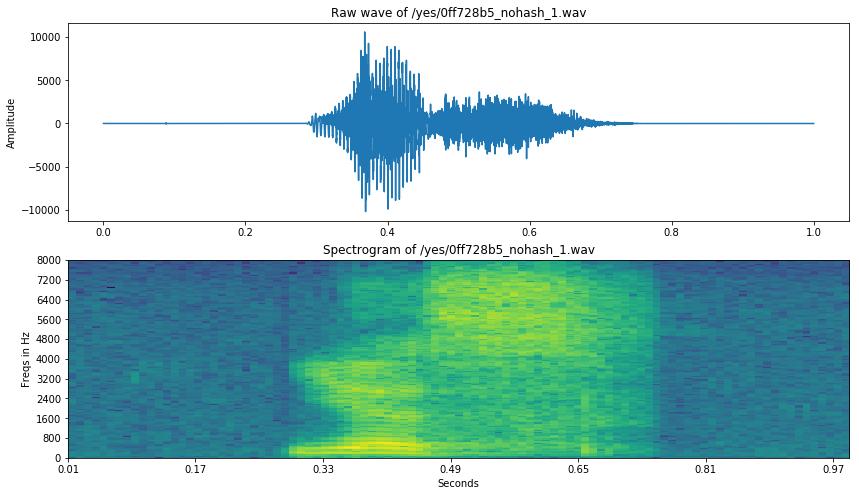

In [122]:
freqs, times, spectrogram = log_specgram(std_samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(std_samples), sample_rate), std_samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

Text(0.5, 0, 'Seconds')

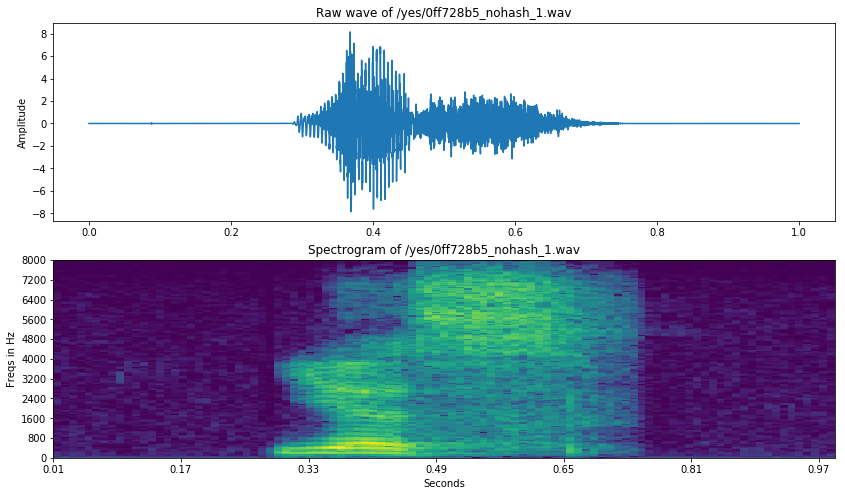

In [124]:
freqs, times, spectrogram = log_specgram(std_samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(std_samples), sample_rate), std_samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [50]:
spectrogram.shape

(99, 161)

In [43]:
def testit2():
    for i in range (1, 1000):
        train_audio_path = '../data/raw/train/audio/'
        filename = '/yes/0a7c2a8d_nohash_0.wav'
        sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)


In [44]:
cProfile.run('testit2()')

         94909 function calls in 0.714 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      999    0.024    0.000    0.503    0.001 <ipython-input-35-21615b10bf2f>:1(log_specgram)
        1    0.008    0.008    0.714    0.714 <ipython-input-43-40428df2a851>:1(testit2)
        1    0.000    0.000    0.714    0.714 <string>:1(<module>)
      999    0.001    0.000    0.008    0.000 _methods.py:34(_sum)
      999    0.002    0.000    0.052    0.000 _numpy_fft.py:250(rfft)
      999    0.000    0.000    0.000    0.000 _numpy_fft.py:66(_unitary)
      999    0.001    0.000    0.001    0.000 function_base.py:13(_index_deprecate)
      999    0.023    0.000    0.037    0.000 function_base.py:25(linspace)
      999    0.005    0.000    0.009    0.000 helper.py:173(rfftfreq)
      999    0.006    0.000    0.008    0.000 numeric.py:1407(rollaxis)
      999    0.001    0.000    0.001    0.000 numeric.py:1927(isscalar)
     2997    0.0